# Outlier detection using DBSCAN and sklearn

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/ml_in_ms_st25/blob/main/04_ex/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->



## Generate data blobs using sklearns `make_blobs` function

<Axes: xlabel='f0', ylabel='f1'>

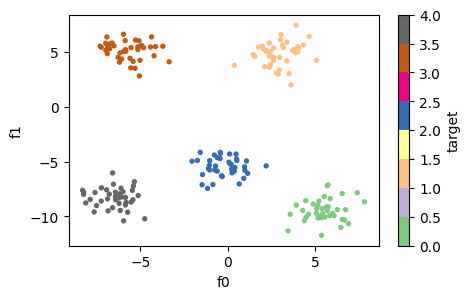

In [9]:
from sklearn.datasets import make_blobs
import pandas as pd

# Make blobs with 200 samples and 5 clusters
data = make_blobs(
    n_samples=200, centers=5, cluster_std=1, n_features=2, random_state=10
)

# Convert data to a pandas dataframe
# data[0] == X, data[1] == y
column_names = [f"f{n}" for n in range(data[0].shape[1])]
df_blob = pd.DataFrame(data[0], columns=column_names)

# add y (or target)
df_blob["target"] = data[1]
df_blob.plot.scatter(x="f0", y="f1", c="target", cmap="Accent", s=8, figsize=(5, 3))

## Add noise to the blobs

,f0,f1,target
198,1.070270,-4.939715,2.0
199,3.448685,-11.328333,0.0
200,0.000000,0.000000,10.0
201,0.000000,-11.000000,10.0
202,-6.000000,-2.500000,10.0
203,6.000000,-2.500000,10.0
204,7.000000,3.000000,10.0


<Axes: xlabel='f0', ylabel='f1'>

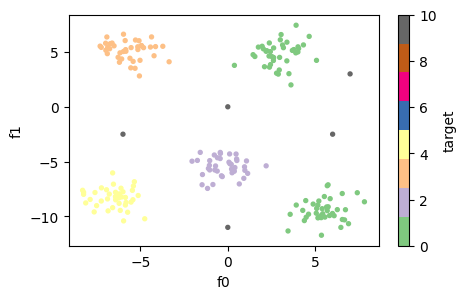

In [10]:
import numpy as np

# define noisy data points
noise = np.array([[0, 0], [0, -11], [-6, -2.5], [6, -2.5], [7, 3]])

# Add target = 10 for each noise data point
noise = np.c_[noise, np.zeros(noise.shape[0]) + 10]


# Add the noisy data to the data frame
df_blob_noise = pd.concat(
    [df_blob, pd.DataFrame(noise, columns=df_blob.columns)]
).reset_index(drop=True)


# Confirm by looking at the tail of the data frame
display(df_blob_noise.tail(7))


# Scatter plot with the noise data
df_blob_noise.plot.scatter(
    x="f0", y="f1", c="target", cmap="Accent", s=8, figsize=(5, 3)
)

### Scale data using StandardScaler from Sklearn


Example for applying the StandardScaler of sklearn from the sklearn website. 

Left before scaling - right after scaling


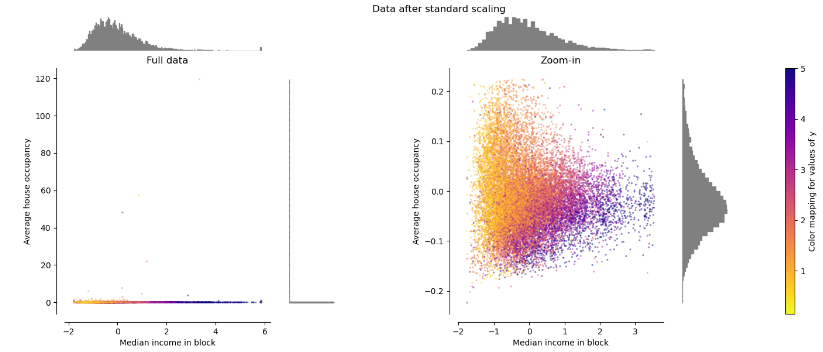

<Axes: xlabel='f0', ylabel='f1'>

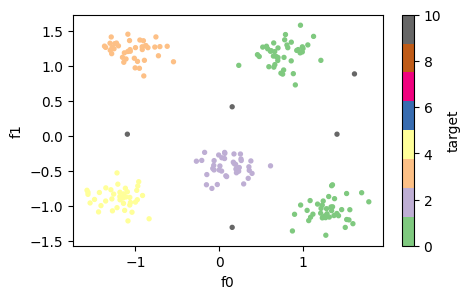

In [11]:
from sklearn.preprocessing import StandardScaler

# Scale features before applying cluster algorithms
# Many ML methods work better with scaled features
# StandardScaler scales data to unit variance
df_blob_noise[["f0", "f1"]] = StandardScaler().fit_transform(
    df_blob_noise[["f0", "f1"]]
)
# Plot to confirm
df_blob_noise.plot.scatter(
    x="f0", y="f1", c="target", cmap="Accent", s=8, figsize=(5, 3)
)

### Find outliers using DBSCAN

DBSCAN is a density based clustering technique that groups together points that are closely packed, while marking outliers.

`A` and `B` belong to one cluster; `N` is an outlier

Read through: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN


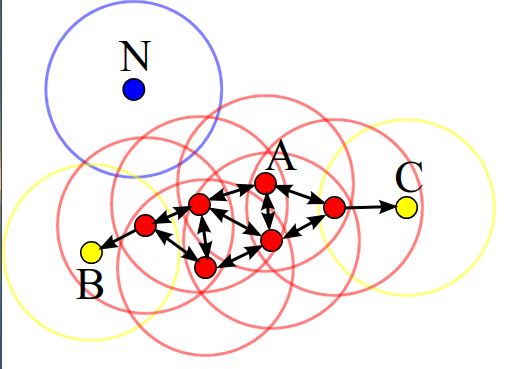

<Axes: xlabel='f0', ylabel='f1'>

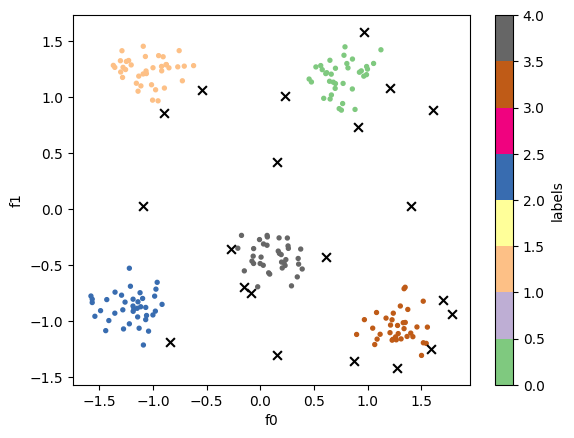

In [12]:
import matplotlib.pyplot as plt

# Import DBSCAN
from sklearn.cluster import DBSCAN


# Set seed to make results reproducible; sklearn uses the seed of numpy, if not otherwise specified
np.random.seed(0)

# object of class DBSCAN
cluster = DBSCAN(eps=0.2, min_samples=10)

# Fit and return cluster label: -1 for outliers; 0 to n for the nth cluster
df_blob_noise["labels"] = cluster.fit_predict(df_blob_noise[["f0", "f1"]].values)

# Init plot
fig, ax = plt.subplots()

# the .query method selects all labels != -1 (all clusters)
df_blob_noise.query("labels != -1").plot.scatter(
    x="f0", y="f1", c="labels", cmap="Accent", ax=ax, s=8
)

# the .query method selects all labels == -1 (outliers), marker = x
df_blob_noise.query("labels == -1").plot.scatter(
    x="f0", y="f1", c="black", ax=ax, marker="x", s=40
)

### Tutorial

This tutorial will help you understand how DBSCAN detects outliers and how its parameters affect clustering results.

---

**1. Add a new outlier**

- In the cell where noise is defined, change:
  ```python
  noise = np.array([[0, 0], [0, -11], [-6, -2.5], [6, -2.5], [7, 3]])
  ```
  to
  ```python
  noise = np.array([[0, 0], [0, -11], [-6, -2.5], [6, -2.5], [8, 3]])
  ```
- Rerun all cells below.
- **Question:** What changed in the scatter plot and the DBSCAN results? Do you observe one more outlier?  
  *Hint: The new noise point is further away from the clusters. Does DBSCAN now mark it as an outlier?*

---

**2. Experiment with DBSCAN parameters**

- Try changing the DBSCAN parameters in the clustering cell:
  ```python
  cluster = DBSCAN(eps=0.2, min_samples=10)
  cluster = DBSCAN(eps=0.2, min_samples=1)
  cluster = DBSCAN(eps=0.2, min_samples=5)
  cluster = DBSCAN(eps=0.9, min_samples=10)
  ```
- For each setting:
  - Rerun the clustering and plotting cells.
  - Observe how the number of clusters and outliers changes.
  - **Questions to consider:**
    - What happens when you decrease `min_samples`?
    - How does increasing `eps` affect the clustering?
    - Which points are marked as outliers in each case?

---

**3. (Optional) Visualize the effect**

- For each parameter setting, count and print the number of outliers:
  ```python
  n_outliers = (df_blob_noise["labels"] == -1).sum()
  print(f"Number of outliers: {n_outliers}")
  ```
- Try plotting the results side by side for easier comparison.

---

**Summary**

- DBSCAN marks points as outliers if they do not have enough neighbors within `eps` distance.
- The choice of `eps` and `min_samples` strongly affects which points are considered outliers and how clusters are formed.
- Experimenting with these parameters helps you understand the sensitivity of DBSCAN to data distribution